# Final project of “Management and Analysis of Physics Datasets”

#### Fontana Francesco (2026924) - Mancini Lorenzo (2019098) - Vicentini Giulio (2021432)

In [1]:
#importing libraries
import nltk 
import dask
from dask.distributed import Client, progress, SSHCluster
import dask.bag as db
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
import time
import tornado
import re
import os
import asyncssh
import sys
import paramiko
import distributed

import warnings
warnings.filterwarnings("ignore")

# Analysis of Covid-19 papers 

 ## 1 -  Word counter distributed algorithm

In this section we will perform a $\textit{Word Counter distributed algorithm}$ over a dataset consisting of *json* files of 1000 research papers on COVID-19, randomly picked from a larger dataset (https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge).

In order to analyse the data, we begin by sanitizing it.<br>
First of all we convert each *json* paper into a single line format with a bash script since the papers are structured.  

\
The above mentioned bash script ("script_json_singleline_convertion.sh") consist in:

$%\qquad \texttt{ cd Desktop/MAPD-B/Data_Processing/Assignment/distributed_computing }$
$\qquad \texttt{ cd "directory_of_notebook" }$

$\qquad \texttt{ mkdir -p data/1000papers_json_singleline}$

$\qquad \texttt{ cd data/1000papers_json}$

$\qquad \texttt{ echo "Converting..."}$

$\qquad \texttt{ for filename in *.json; do}$

$\qquad \qquad \texttt{ #echo \$filename}$

$\qquad \qquad \texttt{ jq -c . \$filename > ../1000papers_json_singleline/\$filename}$

$\qquad \texttt{ done}$

$\qquad \texttt{ echo \$"Done! \n\n"}$

$\qquad \texttt{ echo \$"Directory:  \n" \$(pwd) }$

In [2]:
# Run the script bash to convert papers to a single-line json file
!sh script_json_singleline_conversion.sh

Converting...
^C



In order to implement a Word counter distributed algorith, we begin by counting the occurence of all the words inside a list of documents. This is done by two phases:

 - $\textit{Map phase}$: The frequency of words for each paper is counted.

 - $\textit{Reduce phase}$ : The frequency of words for the whole dataset of 1000 papers taken together is counted.
 
To apply the counter, we need to remove the stop-words. This is done by making use of the *Natural Language Toolkit* dictionary.

In [2]:
# Run only one time in order to download stopwords dictionary
# We import Natural languguage toolkit to remove stop words like a, an, the, i, aren't....and so on.

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Caching the stopwords object. 
#Constructing this each time you call the function can be a bottleneck.
#       courtesy: https://stackoverflow.com/questions/19560498/faster-way-to-remove-stop-words-in-python
cachedStopWords = stopwords.words("english")


# removing few more words from body-text by adding them to a list of stop words
for word in ['et','al','also','may','fig','figure']:
    cachedStopWords.append(word)

# convert a regular pattern to a Regular Expression Object
pattern = re.compile(r'\b(' + r'|'.join(cachedStopWords) + r')\b\s*')

In [4]:
print(cachedStopWords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Create Cluster

Here we make use of the *dask.distributed.SSHCluster* package to create a cluster over a  password-free tunnel SSH between some virtual machines on the same network. We also have created an environment in which each VMs have access to the shared data directory.

*(https://towardsdatascience.com/set-up-a-dask-cluster-for-distributed-machine-learning-31f587b1b553)*

In [5]:
def Cluster( nprocs, nthreads=1,memory_limit="1GB", n_core_VM=4): #number_nodes=3,
    
    scheduler = "10.67.22.84"
    nodes = ["10.67.22.84", "10.67.22.254", "10.67.22.111"]
    
    if nprocs <= n_core_VM: 
        string = ("-"+ nodes[0]) *(nprocs)
        workers = string[1:].split("-")
    elif nprocs <= 2*n_core_VM:
        string = ("-"+ nodes[0])*(n_core_VM) + ("-"+ nodes[1])*(nprocs-n_core_VM)
        workers = string[1:].split("-")
    elif nprocs <= 3*n_core_VM:
        string = ("-"+ nodes[0])*(n_core_VM) +("-"+ nodes[1])*(n_core_VM) +("-"+ nodes[2])*(nprocs-2*n_core_VM)
        workers = string[1:].split("-")
    else:
        print("Warning: Too much cores selected ---> Set all cores available.")
        string = ("-"+ nodes[0])*(n_core_VM) +("-"+ nodes[1])*(n_core_VM) +("-"+ nodes[2])*(nprocs-2*n_core_VM)
        workers = string[1:].split("-")
        
    workers.insert( 0 , scheduler )   
    
    memory = [c for c in memory_limit]
    
    c = SSHCluster( workers,
            connect_options={"known_hosts": None},
            worker_options={"nthreads" : nthreads, "memory_limit":memory_limit},
            scheduler_options={"port": 8786, "dashboard_address": 8787 },
          )  
    
    return c

 
#  Function that close the client and kill also the background processes ID related to dask
#  becouse there is a little bug that doesn't allow to properly close the scheduler using
#  "client.shutdown".  We use a bash script that kill every process of dask both scheduler 
#  and workers; it's usefull when is necessary to execute the same computation changing 
#  the number of workers.

def dask_close_all(): 
    client.close()
    client.shutdown()
    !kill $(ps aux | grep '[d]istributed.cli.dask' | awk '{print $2}')
    !sh data/clusters_script/close_dask.sh


In [6]:
cluster = Cluster (nprocs=12, nthreads=1)
client = Client(cluster)
client

distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:38171'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:34508'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:36910'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

Client Scheduler: tcp://10.67.22.84:8786 Dashboard: http://10.67.22.84:8787/status,Cluster Workers: 12 Cores: 12 Memory: 11.18 GiB


In [7]:
# create dask bag
# use dask bag to read json files. 

b = db.read_text('./data/1000papers_json_singleline/*.json').map(json.loads) # 1 partition for each file
b

dask.bag<loads, npartitions=1000>

In [8]:
# Concatenating the strings contained into the body-text fields of the JSONs
def concatText_list(body_text):
    
    # Concatenating the strings contained into the body-text fields of the JSONs
    

    concat = [item['text'] for item in body_text]
    text = " ".join(concat)
    
    # sub Replaces one or many matches with a string
    text = re.sub('\W+',' ', text)             # remove special characters (.,!)
    text = re.sub(r'\b[0-9]+\b\s*', ' ', text) # remove words containing only numbers
    text = text.lower()                        # set to lowercase
    
    text = pattern.sub('', text)               # remove stop-words
    wordlist = text.split()                    # split text in strings
    
    return wordlist

### Implementation of Regular Expression(RegEx)

We use the RegEX module which consider the following:
 
 - $\quad$ \ $\quad$ Signals a special sequence (can also be used to escape special characters)


 - $\quad$ \W$\quad$ Returns a match where the string DOESN'T contain any word characters


 - $\quad$ $+$ $\quad$ Returns a match for  1 or more repetitions of the preceding *RE*
 
 
 - $\quad$ $*$ $\quad$ Returns a match for  0 or more repetitions of the preceding *RE*
 
 
 - $\quad$ \b $\quad$ Returns a match where the specified characters are at the beginning or at the end of a word (the "r" in the beginning is making sure that the string is being treated as a "raw string")


 - $\quad$ [0-9] $\quad$ Returns a match for any digit between 0 and 9


 - $\quad$ \s $\quad$ Returns a match where the string contains a white space character

A regular expression followed by an asterisk ( * ) matches zero or more occurrences of the regular expression. If there is any choice, the first matching string in a line is used. A regular expression followed by a plus sign ( + ) matches one or more occurrences of the one-character regular expression.

*re.compile* $\rightarrow$ Compile a regular expression pattern into a regular expression object, which can be used for matching using its *match( )*, *search( )* and other methods, described below.

The expression’s behaviour can be modified by specifying a flags value. Values can be any of the following variables, combined using bitwise OR (the | operator).

*(https://www.w3schools.com/python/python_regex.asp)*

# MAP PHASE

In [9]:
# Map phase
#init_bag = b.map(lambda record: record['body_text']).map(concatText_list) 

init_bag = b.pluck("body_text").repartition(50).map(concatText_list) 
map_phase = init_bag.map(Counter) # Counter from library collections

In [10]:
%%time
results = map_phase.compute()

CPU times: user 358 ms, sys: 89.8 ms, total: 448 ms
Wall time: 2.5 s


In [11]:
results[0]

Counter({'said': 1,
         'crisis': 3,
         'reveals': 1,
         'character': 2,
         'covid': 19,
         'pandemic': 4,
         'revealed': 1,
         'inequitable': 1,
         'u': 2,
         'health': 10,
         'care': 2,
         'system': 6,
         'alarming': 1,
         'death': 2,
         'rates': 2,
         'among': 1,
         'african': 15,
         'americans': 12,
         'nationwide': 1,
         'represent': 1,
         'third': 1,
         'hospitalized': 1,
         'patients': 1,
         'make': 2,
         'population': 1,
         'chicago': 1,
         'one': 1,
         'nation': 1,
         'hotspots': 1,
         'american': 3,
         'cases': 3,
         'deaths': 1,
         'virus': 3,
         'several': 1,
         'pathways': 3,
         'contribute': 3,
         'racial': 5,
         'disparities': 6,
         'first': 2,
         'must': 3,
         'consider': 1,
         'biological': 4,
         'underpinnings': 1,
      

In [12]:
# function to sort the word and its frequency from higher to lower for each paper.
def plot_bar(results):
    def data_sort(results):
        total = list(results.keys()), list(results.values()) 
        data = pd.DataFrame(total).T
        data.columns = ['Word', 'Count']
        data = data.sort_values(['Count'], ascending=False)
        return data
    
    data = data_sort(results)
    # just get unique words
    names = data['Word'].unique()
    
    words = []
    counts = []
    
    # get only top 10 words for each paper
    for name in names[0:10]:
        data_filtered = data[data['Word'] == name]
        val = data_filtered['Count'].sum()
        words.append(name)
        counts.append(val)
        
    return(words, counts)

In [13]:
words_1, counts_1 = plot_bar(results[1])
words_2, counts_2 = plot_bar(results[2])
words_3, counts_3 = plot_bar(results[3])
words_4, counts_4 = plot_bar(results[4])

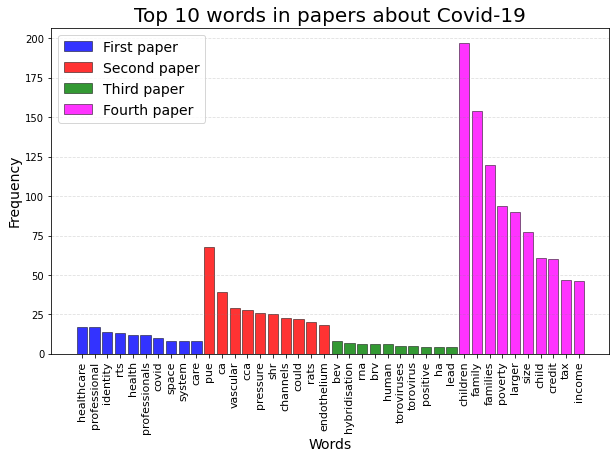

In [14]:
fig = plt.figure(figsize=(10, 6))
plt.bar(words_1, counts_1, label = 'First paper', edgecolor = "black", lw=0.6, alpha = 0.8, color = "blue")
plt.bar(words_2, counts_2, label = 'Second paper', edgecolor = "black", lw=0.6, alpha = 0.8, color = "red")
plt.bar(words_3, counts_3, label = 'Third paper', edgecolor = "black", lw=0.6, alpha = 0.8, color = "green")
plt.bar(words_4, counts_4,  label = 'Fourth paper', edgecolor = "black", lw=0.6, alpha = 0.8, color = "magenta")


plt.title('Top 10 words in papers about Covid-19',fontsize = 20)
plt.xlabel('Words',fontsize = 14)
plt.ylabel('Frequency',fontsize = 14)
plt.xticks(rotation = 90 , fontsize = 11)
plt.legend(fontsize = 14)
plt.grid(axis = "y", alpha = 0.25, color = 'grey', linestyle = "--")
plt.show()
fig.savefig("top10.pdf", transparent = True,  bbox_inches = 'tight', pad_inches = 0)

# REDUCE PHASE

In [15]:
## Reduce phase
reduce_phase = init_bag.flatten().frequencies(sort=True)

In [16]:
%%time
results = reduce_phase.compute()

CPU times: user 719 ms, sys: 72 ms, total: 792 ms
Wall time: 6.32 s


In [17]:
results

[('patients', 11334),
 ('covid', 9831),
 ('data', 8244),
 ('study', 7638),
 ('using', 5912),
 ('health', 5833),
 ('used', 5523),
 ('e', 5494),
 ('one', 5354),
 ('time', 5291),
 ('sars', 5208),
 ('cells', 5111),
 ('p', 5082),
 ('c', 4927),
 ('cov', 4920),
 ('infection', 4651),
 ('two', 4567),
 ('n', 4555),
 ('virus', 4502),
 ('disease', 4472),
 ('studies', 4365),
 ('based', 4326),
 ('however', 4224),
 ('model', 4216),
 ('use', 4041),
 ('cases', 4016),
 ('results', 4008),
 ('high', 3987),
 ('number', 3847),
 ('different', 3792),
 ('first', 3719),
 ('analysis', 3671),
 ('reported', 3621),
 ('cell', 3596),
 ('risk', 3542),
 ('protein', 3504),
 ('could', 3449),
 ('viral', 3422),
 ('group', 3383),
 ('clinical', 3363),
 ('table', 3250),
 ('treatment', 3215),
 ('well', 3206),
 ('g', 3203),
 ('care', 3197),
 ('research', 3132),
 ('found', 3012),
 ('pandemic', 3009),
 ('b', 2988),
 ('r', 2985),
 ('de', 2959),
 ('system', 2942),
 ('information', 2872),
 ('due', 2844),
 ('higher', 2842),
 ('includ

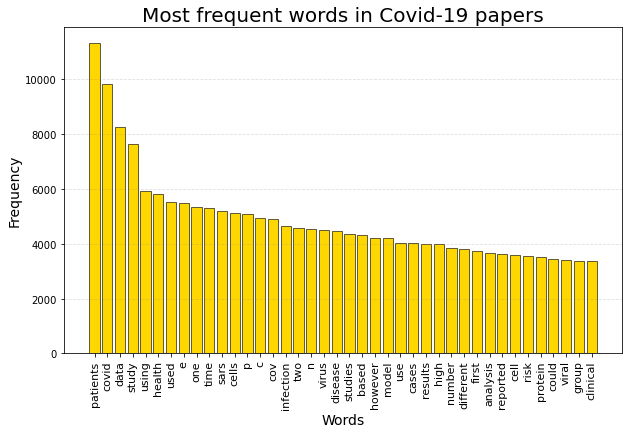

In [18]:
#plotting the top 40 words. 
words = []
counts = []
for i in range(40):
    words.append(results[i][0])
    counts.append(results[i][1])


fig = plt.figure(figsize = (10, 6))
plt.bar(words, counts,color = "gold", edgecolor = "black", lw=0.6)
plt.title('Most frequent words in Covid-19 papers',fontsize = 20)
plt.xlabel('Words',fontsize = 14)
plt.ylabel('Frequency',fontsize = 14)
plt.xticks(rotation = 90, fontsize = 11)
plt.grid(axis = "y", alpha = 0.25, color = 'grey', linestyle = "--")
plt.show()
fig.savefig("mostfreqwords.pdf", transparent = True,  bbox_inches = 'tight', pad_inches = 0)

# Effect of different partitioning

We change the number of bag partitions in a range [ 1, 1000 ] in order to find which partitions takes less execution time and how it affects the performance.

In [23]:
partition_time = []
partitions = [1,2,3,4,5,10,20,50,60,70,80,90,100,250,500,750,1000,2000]

for npart in partitions:
    
    start_time = time.time()
    
    b = db.read_text('data/papers_in_json_singleline/*.json').map(json.loads).repartition(npartitions = npart)
    bag = b.pluck("body_text").map(concatText_list)
    map_phase = bag.map(Counter)
    reduce_phase = bag.flatten().frequencies(sort=True)
    
    map_phase, reduce_phase = dask.compute(map_phase, reduce_phase)
    
    end_time = time.time()

    print('# partitions:',npart,'\t Execution time:', end_time-start_time )
    partition_time.append(end_time-start_time)

# partitions: 1 	 Execution time: 18.014737606048584
# partitions: 2 	 Execution time: 13.228745460510254
# partitions: 3 	 Execution time: 10.715841054916382
# partitions: 4 	 Execution time: 10.431742429733276
# partitions: 5 	 Execution time: 10.588537454605103
# partitions: 10 	 Execution time: 8.535691976547241
# partitions: 20 	 Execution time: 8.189897060394287
# partitions: 50 	 Execution time: 8.475441932678223
# partitions: 60 	 Execution time: 8.340466499328613
# partitions: 70 	 Execution time: 8.78187870979309
# partitions: 80 	 Execution time: 8.150811672210693
# partitions: 90 	 Execution time: 8.432350158691406
# partitions: 100 	 Execution time: 8.255001783370972
# partitions: 250 	 Execution time: 8.455244064331055
# partitions: 500 	 Execution time: 8.946032047271729
# partitions: 750 	 Execution time: 9.062098026275635
# partitions: 1000 	 Execution time: 9.045414686203003
# partitions: 2000 	 Execution time: 10.636701107025146


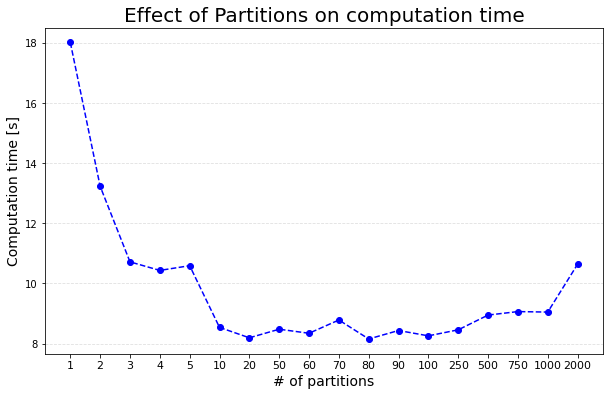

In [24]:
# Bar plot of Time vs Number of partitions
fig = plt.figure(figsize = (10, 6))
plt.plot(range(len(partition_time)),partition_time, color = 'blue', linestyle = "--",  marker = 'o')#, edgecolor = "black", alpha = 0.8)

plt.title('Effect of Partitions on computation time',fontsize = 20)
plt.xlabel('# of partitions',fontsize = 14)
plt.ylabel('Computation time [s]',fontsize = 14)
plt.xticks(range(len(partitions)), partitions, fontsize = 11)
plt.grid(axis = "y", alpha = 0.25, color = 'grey', linestyle = "--")
plt.show()
fig.savefig("partitions.pdf", transparent = True,  bbox_inches = 'tight', pad_inches = 0)

In [23]:
dask_close_all()

From the above plot we could see that in the first part the execution times quickly decrease starting from the left side. It could also be seen how the time slightly increase when the number of partition is high.
<br>In fact, there is a cost to having both too many or too few partitions.

From what said here above, we could say that with a ***number of partitions ~ [ 50 , 100 ]*** the algorithm performs better and the computation time is smaller.

Partitions should fit comfortably in memory (smaller than a gigabyte) but also not be too many. Every operation on every partition takes the central scheduler a few hundred microseconds to be processed. If you have a few thousand tasks this is barely notable, but it is nice to reduce the number if possible.

## Effect of Number of workers

Here instead we see how vary the execution time  when the number workers for the distributed computation changed.

We span from 1 worker to 12 worker ( we have 3 VMs with 4 cores each).
<br>Each worker has:
 - 1 thread
 - 1 GB of memory

In [24]:
N_workers = list(range(1,13))

In [25]:
# We consider number of partition=50 (optimal) from the previous conclusion.
worker_times=[]

for workers in N_workers:

    # Create a cluster with a given number of workers
    tmpCluster = Cluster(nprocs = workers, 
                         nthreads=1,
                         memory_limit='1GB'
                        )
    client = Client(tmpCluster)

    start_time = time.time()
    b = db.read_text('data/papers_in_json_singleline/*.json').map(json.loads).repartition(npartitions=50)
    bag = b.map(lambda record: record['body_text']).map(concatText_list)
    map_phase = bag.map(Counter)
    reduce_phase = bag.flatten().frequencies(sort=True)

    map_phase, reduce_phase = dask.compute(map_phase, reduce_phase)

    end_time = time.time()
    worker_times.append(end_time-start_time)

    dask_close_all() # close both client and scheduler 

distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:44200'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:34763


kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:45072'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:39004'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:42911
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:35798'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:34331'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:40127'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker 

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:35553'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:46851'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:34941'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny 

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:37985'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:34740'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:44122'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:36670'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:34333'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:32894'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nann

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:33574'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:46586'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:42860'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:45530'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:40663'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:37122'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:35955'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:45960'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:40666'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:34052
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:45232'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:41895'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

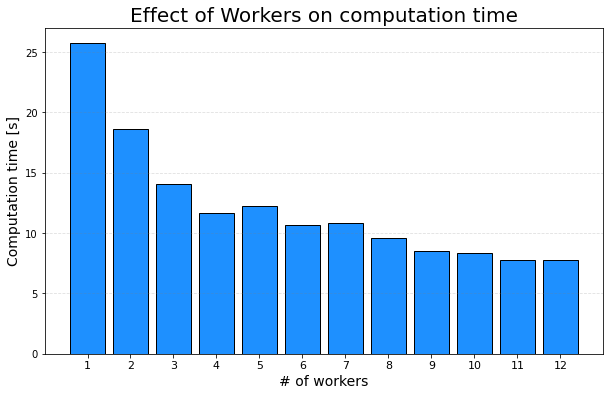

In [31]:
# Bar plot of Time vs Number of workers
plt.figure(figsize=(10, 6))
plt.bar(N_workers, worker_times, edgecolor = "black", color = "dodgerblue")
plt.title('Effect of Workers on computation time',size=20)
plt.xlabel('# of workers',size=14)
plt.ylabel('Computation time [s]',size=14)
plt.xticks(N_workers,size=11)
plt.grid(axis = "y", alpha = 0.25, color = 'grey', linestyle = "--")
plt.show()
fig.savefig("workers.pdf", transparent = True,  bbox_inches = 'tight', pad_inches = 0)

From above, we could see how increasing the number of workers, the computation time decreases. **12 workers  with  1 thread each, ( partition=50 ) is found to be optimal.** 

The decreasing of execution time when the number of workers increase it's not a fixed rule.
<br>
In fact if we have a small task and we distribute it among several nodes we could see that the computation become inefficient and the execution time increase, caused by the ***overhead***. 

In general when we have to deal with a cluster we have to think about the overhead.<br>
We can image the overhead like the the computational time necessary to process the data (in this case are *json* files).<br>
Typically in a cluster there two kind of overhead:

- ***Scheduler overhead*** - in serializing the objects that must be sent to workers
- ***Connection overhead*** - due to the speed of the network connection between the cluster nodes

In the first case, the scheduler adds about one millisecond of overhead per task of *Future object*.<br> Despite this may sound fast and irrelevant, it's quite slow if you run a large number of tasks. Under this perspective, a larger number of the task means a larger amount of time to create the Future objects of the tasks.
From what already said above, if your functions run faster than 100ms or so then you might not see any speedup from using distributed computing, but even worse, probably you might see that the performances get worse.

In the second case things are different. The connection overhead may depends from several factors including the stability of the network, the type (wired or WiFi or optic fibe), and bandwith of the network.

This is what is happening in the here.

In [26]:
#dask_close_all()

### Grid Search: partitions and workers

Here we permformed a Grid Search analysis of the effects both of the partitions and workers.

In [32]:
def time_grid(workers, partitions):
    
    # Create a local cluster with as many workers as cores 
    tmpCluster = Cluster(nprocs = workers, 
                         nthreads=1,
                         memory_limit='1GB'
                        )
    client = Client(tmpCluster)
    
    start_time = time.time()
    b = db.read_text('data/papers_in_json_singleline/*.json').map(json.loads).repartition(npartitions=partitions)
    init = b.map(lambda record: record['body_text']).map(concatText_list)
    map_phase = init.map(Counter)
    reduce_phase = init.flatten().frequencies(sort=True)

    map_phase, reduce_phase = dask.compute(map_phase, reduce_phase)
    
    end_time = time.time()
    
    dask_close_all() # close both client and scheduler 
    
    return (end_time-start_time)

In [33]:
# Number of workers
workers = [1,2,4,6,8,12]
# Partitions factor
partitions = [1, 5, 20, 50,100] 

times = np.zeros((len(workers),len(partitions))) 

# create a computation time matrix for all combinations of workers and partitions
for w in range(len(workers)):
    for p in range(len(partitions)):
        times[w][p] = time_grid(workers[w],partitions[p])

distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:43614'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:37565


kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:33563'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:35507


kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:36627'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:41246


kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:45112'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:34262


kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:42053'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:42711


kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:34304'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:34205'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:35925
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:32962'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:38069'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:38690
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:35430'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:37349'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:41832
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:44205'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:44077'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:42919
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:35580'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:43792'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:46210
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:32948'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:34669'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:44710'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny 

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:33528'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:33775'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:39478'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny 

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:34191'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:40381'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:41973'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny 

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:35369'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:34665'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:35834'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny 

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:36511'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:38005'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:38415'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny 

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:33359'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:45865'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:36621'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nann

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:37740'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:35468'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:46040'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:36141'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:35419'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:36685'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nann

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:44690'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:36854'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:45572'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:44483'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:38890'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:44702'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:41215'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:37649'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:37860'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:38092'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:43906'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:43632'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:40418'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:33638'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:41075'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:45990'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:39037'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:45961'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:45146'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:38758'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:41477'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:42035'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:43263'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:41463'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:36214'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:44418'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.111:39513
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.254:38861
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.111:36411
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.254:34199
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.111:41599
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.111:33709
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.254:40172
distributed.

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client -

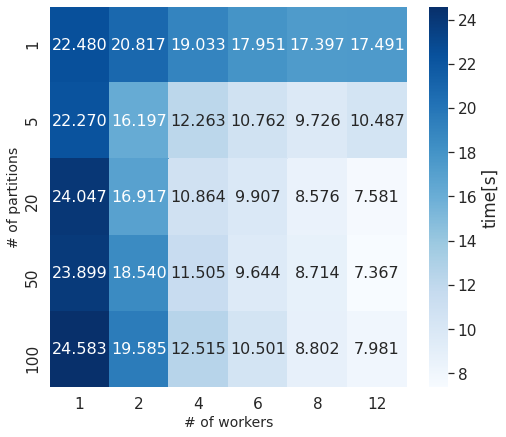

In [42]:
df_cm = pd.DataFrame(times.T, partitions, workers)


fig = plt.figure(figsize=(8,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt=".3f",
           cbar_kws={'label':'time[s]'},cmap="Blues")
plt.xlabel('# of workers',fontsize=14)
plt.ylabel('# of partitions',fontsize=14)
plt.show()
fig.savefig("grid.pdf", transparent = True,  bbox_inches = 'tight', pad_inches = 0)

*It can be seen that the best times are observed for* ***12 workers*** *with*  ***partitions in range [ 50 , 100 ]*** *(as mentioned before)*.


In [32]:
#dask_close_all()